In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

%matplotlib inline

In [110]:
df_usa = pd.read_excel(r'C:\Users\mrosk\OneDrive\Desktop\Mental-Health-in-Tech\Subsets\usa_subset.xlsx')

In [111]:
df_usa.drop(df_usa.columns[0], axis=1, inplace =True)
df_usa.head() 

,num_employees,is_tech_company,age,gender,country_of_residence,works_remotely,US_state_work,US_state_live,is_self_employed,back_end_developer,...,pro_addictive,pro_anxiety_stress,pro_autism_develop,pro_mood_disorder,pro_ptsd,pro_personality,pro_other,willing_discuss_mental_health_in_interview,willing_discuss_physical_health_in_interview,has_previous_employers
0,6-25,1.0,29,Male,US,Never,Illinois,Illinois,0,1,...,0,1,0,1,0,0,0,No,Maybe,1
1,6-25,0.0,43,Female,US,Sometimes,Illinois,Illinois,0,1,...,0,1,0,0,0,0,0,No,Maybe,1
2,26-100,1.0,30,Male,US,Sometimes,Tennessee,Tennessee,0,1,...,0,0,0,0,0,0,0,Yes,Yes,1
3,More than 1000,1.0,37,Female,US,Always,Virginia,Virginia,0,1,...,1,1,0,0,0,0,0,No,No,1
4,26-100,0.0,44,Female,US,Sometimes,California,California,0,1,...,0,0,0,1,0,0,0,Maybe,Maybe,1


In [112]:
usa_states = gpd.read_file(r'C:\Users\mrosk\OneDrive\Desktop\Mental-Health-in-Tech\EDA\cb_2018_us_state_500k')
usa_states = usa_states[~usa_states.STATEFP.isin(["72", "69", "60", "66", "78"])]

usa_states = usa_states.to_crs("ESRI:102003")

def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]

    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)

    return pd.concat([df_main_land, df_alaska, df_hawaii])

usa_states = adjust_maps(usa_states)

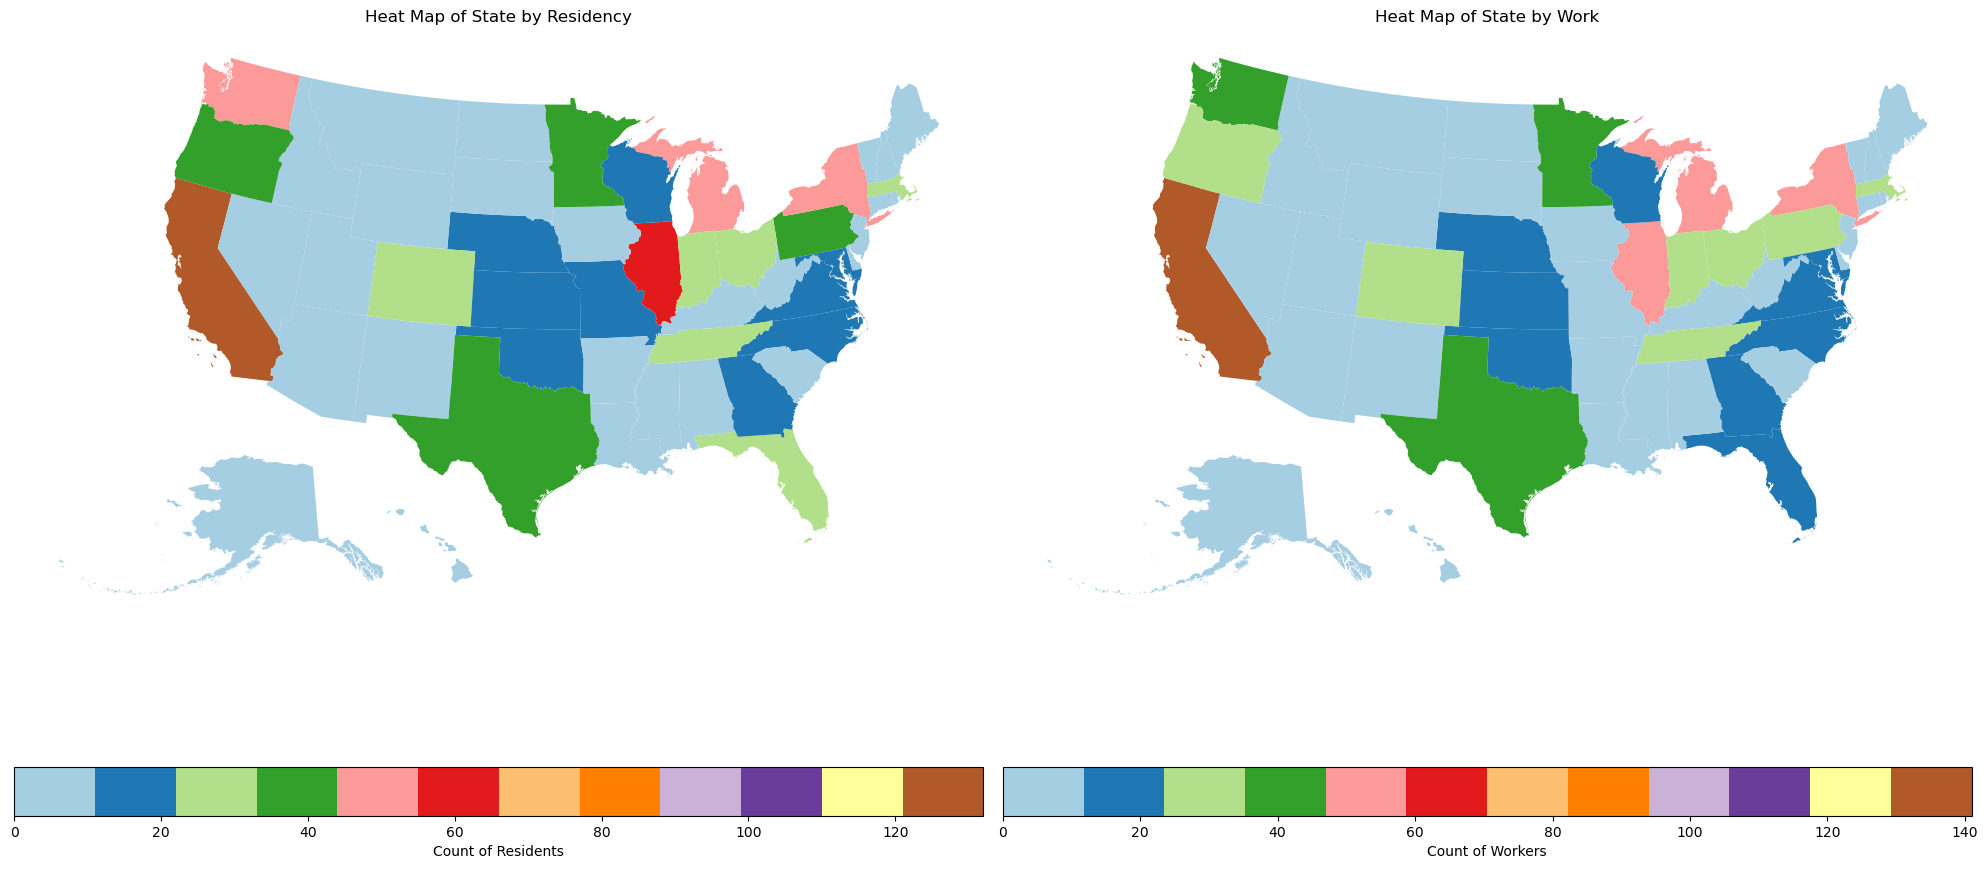

In [113]:
# Aggregate data to get counts per state for living and working
state_live_counts = df_usa['US_state_live'].value_counts().reset_index()
state_live_counts.columns = ['state', 'live_count']

state_work_counts = df_usa['US_state_work'].value_counts().reset_index()
state_work_counts.columns = ['state', 'work_count']

# Merge the counts with the geometries
# Ensure your state names in usa_states match the 'state' column in your counts
usa_states = usa_states.merge(state_live_counts, how='left', left_on='NAME', right_on='state')
usa_states = usa_states.merge(state_work_counts, how='left', left_on='NAME', right_on='state')

# Fill NaN values with 0 where there are no counts
usa_states['live_count'] = usa_states['live_count'].fillna(0)
usa_states['work_count'] = usa_states['work_count'].fillna(0)

# Plotting with adjusted sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # Increase the width and height as needed

usa_states.plot(column='live_count', ax=ax1, legend=True,
                legend_kwds={'label': "Count of Residents", 'orientation': "horizontal"},
                cmap='Paired',missing_kwds={'color' : 'lightgrey'})  # Adjust the colormap if needed
ax1.set_title('Heat Map of State by Residency')
ax1.set_axis_off()

usa_states.plot(column='work_count', ax=ax2, legend=True,
                legend_kwds={'label': "Count of Workers", 'orientation': "horizontal"},
                cmap='Paired',missing_kwds={'color' : 'lightgrey'})  # Adjust the colormap if needed
ax2.set_title('Heat Map of State by Work')
ax2.set_axis_off()

plt.tight_layout()  # Adjust layout to fit everything well
plt.show()